In [1]:
import yfinance as yf
import numpy as np
import pandas as pd

# GLD ETF daily prices (10 years)
gold = yf.download("GLD", start="2015-01-01", end="2025-08-15")



gold['log_return'] = np.log(gold['Close'] / gold['Close'].shift(1))
gold.dropna(inplace=True)##remove the first row which is going to have a nan value

##Lets calculate realised volatility(its rolling standard deviation of last 20 day prices)
gold['realized_vol'] = gold['log_return'].rolling(window=20).std() * np.sqrt(252)

gold.dropna(inplace=True)


/tmp/ipython-input-1771051979.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GLD", start="2015-01-01", end="2025-08-15")
[*********************100%***********************]  1 of 1 completed


In [2]:
gold

Price,Close,High,Low,Open,Volume,log_return,realized_vol
Ticker,GLD,GLD,GLD,GLD,GLD,,
Date,,,,,,,
2015-02-02,122.419998,123.160004,121.820000,121.839996,8885200,-0.008378,0.194222
2015-02-03,121.050003,121.760002,120.559998,121.739998,8255900,-0.011254,0.196034
2015-02-04,121.580002,122.220001,120.919998,121.629997,5386700,0.004369,0.193277
2015-02-05,121.790001,121.830002,120.610001,120.980003,6879900,0.001726,0.191090
2015-02-06,118.639999,119.519997,117.949997,119.150002,13206900,-0.026205,0.215358
...,...,...,...,...,...,...,...
2025-08-08,313.049988,313.529999,311.000000,312.350006,19886800,-0.000224,0.144358
2025-08-11,308.549988,309.660004,307.630005,308.619995,10326700,-0.014479,0.153442


In [3]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, subplot_titles=('Gold Close Price vs Date', 'Gold Log Returns vs Date'))

# Plot Close Price
fig.add_trace(go.Scatter(x=gold.index, y=gold['Close'], mode='lines', name='Close Price'),
              row=1, col=1)

# Plot Log Returns
fig.add_trace(go.Scatter(x=gold.index, y=gold['log_return'], mode='lines', name='Log Returns'),
              row=2, col=1)

fig.update_layout(height=800, showlegend=False)
fig.show()

Test Train Split Block

In [4]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Split: Train on 2015-2024 (9 years), Test on 2024-2025 (1 year)
split_date = '2024-08-11'  # One year ago from your end date

train_data = gold[gold.index < split_date].copy()
test_data = gold[gold.index >= split_date].copy()

print(f"Training period: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing period: {test_data.index.min()} to {test_data.index.max()}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Create features for both sets
def create_features(data):
    data = data.copy()
    data['vol_lag1'] = data['realized_vol'].shift(1)
    data['return_lag1'] = data['log_return'].shift(1)
    data.dropna(inplace=True)
    return data

train_data = create_features(train_data)
test_data = create_features(test_data)

# Prepare X, y
X_train = train_data[['vol_lag1', 'return_lag1']]
y_train = train_data['realized_vol']
X_test = test_data[['vol_lag1', 'return_lag1']]
y_test = test_data['realized_vol']

Training period: 2015-02-02 00:00:00 to 2024-08-09 00:00:00
Testing period: 2024-08-12 00:00:00 to 2025-08-14 00:00:00
Train samples: 2397
Test samples: 253


Calculating Metrics

In [5]:
def calculate_metrics(y_true, y_pred, model_name):
    """Calculate all metrics"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # MAPE calculation (handle division by zero)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{model_name} Results:")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"R²: {r2:.4f}")

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

Volatility Forecasting

In [6]:
##Volatility Forecasting:
#Model 1: Implement Random Forests
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit


In [7]:


# Random Forest hyperparameters
rf_params = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None, 0.5],
    'max_samples': [0.7, 0.8, 0.9, None]
}

# Time series CV
tscv = TimeSeriesSplit(n_splits=5, gap=1)

# Random Forest model
rf = RandomForestRegressor(random_state=44, n_jobs=-1, oob_score=True)

# Hyperparameter tuning
rf_search = RandomizedSearchCV(
    rf, rf_params, n_iter=50, cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=44, n_jobs=-1, verbose=1
)

# Train
print("Training Random Forest...")
rf_search.fit(X_train, y_train)

print(f"Best RF params: {rf_search.best_params_}")

# Predict and evaluate
rf_pred = rf_search.predict(X_test)
rf_metrics = calculate_metrics(y_test, rf_pred, "Random Forest")

# Feature importance
rf_importance = rf_search.best_estimator_.feature_importances_
print(f"Feature Importance - vol_lag1: {rf_importance[0]:.3f}, return_lag1: {rf_importance[1]:.3f}")

Training Random Forest...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF params: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_samples': 0.8, 'max_features': None, 'max_depth': 15}

Random Forest Results:
RMSE: 0.009707
MAE: 0.006589
MAPE: 4.02%
R²: 0.9693
Feature Importance - vol_lag1: 0.993, return_lag1: 0.007


In [8]:
#Model2:Naive Forecast


# Naive Model: Tomorrow's volatility = Today's volatility


# Create naive predictions for test set
# Use the last available volatility from each point to predict next
naive_predictions = []

for i in range(len(test_data)):
    if i == 0:
        # For first test prediction, use last training volatility
        naive_pred = train_data['realized_vol'].iloc[-1]
    else:
        # Use previous day's actual volatility
        naive_pred = test_data['realized_vol'].iloc[i-1]

    naive_predictions.append(naive_pred)

naive_predictions = np.array(naive_predictions)

# Calculate metrics
naive_metrics = calculate_metrics(y_test, naive_predictions, "Naive Model")


Naive Model Results:
RMSE: 0.009039
MAE: 0.005705
MAPE: 3.46%
R²: 0.9733


In [9]:
#Model3: Rolling Mean(-5 day,10 day, 20 day)
# Test different window sizes
window_sizes = [5, 10, 20, 30]
rolling_results = {}

for window in window_sizes:
    print(f"\nTesting window size: {window} days")

    # Combine train and test for continuous rolling calculation
    full_data = pd.concat([train_data, test_data])

    # Calculate rolling average
    full_data['vol_rolling'] = full_data['realized_vol'].rolling(window=window).mean()

    # Get predictions for test period
    test_start_idx = len(train_data)
    rolling_predictions = full_data['vol_rolling'].iloc[test_start_idx:test_start_idx + len(test_data)].values

    # Handle any NaN values
    if np.any(np.isnan(rolling_predictions)):
        print(f"Warning: NaN values found for window {window}")
        continue

    # Calculate metrics
    metrics = calculate_metrics(y_test, rolling_predictions, f"Rolling Average ({window} days)")
    rolling_results[window] = {
        'metrics': metrics,
        'predictions': rolling_predictions
    }

# Find best rolling average model
best_window = min(rolling_results.keys(), key=lambda x: rolling_results[x]['metrics']['RMSE'])
best_rolling_metrics = rolling_results[best_window]['metrics']
best_rolling_predictions = rolling_results[best_window]['predictions']

print(f"\nBest Rolling Average: {best_window} days window")
print(f"Best Rolling RMSE: {best_rolling_metrics['RMSE']:.6f}")


Testing window size: 5 days

Rolling Average (5 days) Results:
RMSE: 0.010591
MAE: 0.007576
MAPE: 4.55%
R²: 0.9634

Testing window size: 10 days

Rolling Average (10 days) Results:
RMSE: 0.018862
MAE: 0.013567
MAPE: 7.84%
R²: 0.8839

Testing window size: 20 days

Rolling Average (20 days) Results:
RMSE: 0.032680
MAE: 0.024699
MAPE: 13.95%
R²: 0.6516

Testing window size: 30 days

Rolling Average (30 days) Results:
RMSE: 0.042826
MAE: 0.032396
MAPE: 18.33%
R²: 0.4017

Best Rolling Average: 5 days window
Best Rolling RMSE: 0.010591


GARCH(1,1) Baby!

In [11]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.5 MB/s eta 0:00:00


In [13]:
from arch import arch_model
import matplotlib.pyplot as plt
from scipy import stats

In [14]:
# Get returns
train_returns = train_data['log_return'].dropna()
test_returns = test_data['log_return'].dropna()

print(f"Training returns: {len(train_returns)} observations")
print(f"Test returns: {len(test_returns)} observations")
print(f"Training period: {train_returns.index[0]} to {train_returns.index[-1]}")
print(f"Test period: {test_returns.index[0]} to {test_returns.index[-1]}")

# Convert to percentage returns for GARCH
train_returns_pct = train_returns * 100
test_returns_pct = test_returns * 100

print(f"\nReturn statistics (%):")
print(f"Mean: {train_returns_pct.mean():.4f}")
print(f"Std: {train_returns_pct.std():.4f}")
print(f"Skewness: {stats.skew(train_returns_pct):.4f}")
print(f"Kurtosis: {stats.kurtosis(train_returns_pct):.4f}")

Training returns: 2396 observations
Test returns: 252 observations
Training period: 2015-02-03 00:00:00 to 2024-08-09 00:00:00
Test period: 2024-08-13 00:00:00 to 2025-08-14 00:00:00

Return statistics (%):
Mean: 0.0253
Std: 0.8831
Skewness: -0.1535
Kurtosis: 2.9463


Retruns are changed to Percentages for biggerf numbers, else smaller numbers will result in tiny gradients and pose problems in numerical optimisation

In [15]:
# Define the model
garch_model = arch_model(
    train_returns_pct,
    vol='GARCH',
    p=1,  # GARCH lag
    q=1,  # ARCH lag
    mean='constant',  # Constant mean model
    dist='normal',    # Normal distribution assumption
    rescale=False     # Don't rescale (we already converted to %)
)

# Fit the model
garch_fitted = garch_model.fit(disp='off', show_warning=False)

print("GARCH(1,1) Model fitted successfully!")
print("\nModel Summary:")
print(garch_fitted.summary())

GARCH(1,1) Model fitted successfully!

Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3007.59
Distribution:                  Normal   AIC:                           6023.19
Method:            Maximum Likelihood   BIC:                           6046.31
                                        No. Observations:                 2396
Date:                Sat, Aug 16 2025   Df Residuals:                     2395
Time:                        07:32:58   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [16]:
# Extract parameters
params = garch_fitted.params

# Mean equation parameter
mu = params['mu']

# Volatility equation parameters
omega = params['omega']
alpha = params['alpha[1]']  # ARCH parameter
beta = params['beta[1]']    # GARCH parameter

print("="*40)
print("GARCH PARAMETERS")
print(f"Mean (μ): {mu:.6f}")
print(f"Omega (ω): {omega:.8f}")
print(f"Alpha (α): {alpha:.6f}")
print(f"Beta (β): {beta:.6f}")

# Parameter significance
print("\nParameter Significance (t-stats):")
print(f"Omega t-stat: {garch_fitted.tvalues['omega']:.3f}")
print(f"Alpha t-stat: {garch_fitted.tvalues['alpha[1]']:.3f}")
print(f"Beta t-stat: {garch_fitted.tvalues['beta[1]']:.3f}")

GARCH PARAMETERS
Mean (μ): 0.011448
Omega (ω): 0.01275382
Alpha (α): 0.042699
Beta (β): 0.941177

Parameter Significance (t-stats):
Omega t-stat: 1.192
Alpha t-stat: 2.353
Beta t-stat: 31.045


In [17]:
def assess_garch_properties(omega, alpha, beta):
    """Comprehensive GARCH diagnostics"""
    print("="*40)
    print("GARCH MODEL DIAGNOSTICS")
    print("="*40)

    # 1. Parameter constraints
    print("1. Parameter Constraints:")
    print(f"   ω > 0: {omega > 0} (ω = {omega:.8f})")
    print(f"   α ≥ 0: {alpha >= 0} (α = {alpha:.6f})")
    print(f"   β ≥ 0: {beta >= 0} (β = {beta:.6f})")

    # 2. Mean reversion test
    persistence = alpha + beta
    mean_reverting = persistence < 1

    print(f"\n2. Mean Reversion Analysis:")
    print(f"   Persistence (α + β): {persistence:.6f}")
    print(f"   Mean reverting: {mean_reverting}")
    print(f"   Distance from unit root: {1 - persistence:.6f}")

    if mean_reverting:
        # 3. Long-term volatility
        long_term_vol_pct = np.sqrt(omega / (1 - persistence))
        long_term_vol_decimal = long_term_vol_pct / 100  # Convert back to decimal

        print(f"\n3. Long-term Volatility:")
        print(f"   VL = √(ω/(1-α-β)) = {long_term_vol_pct:.4f}% daily")
        print(f"   VL (decimal): {long_term_vol_decimal:.6f}")
        print(f"   VL (annualized): {long_term_vol_decimal * np.sqrt(252):.4f}")

        # 4. Half-life of shocks
        half_life = np.log(0.5) / np.log(persistence)
        print(f"\n4. Shock Persistence:")
        print(f"   Half-life: {half_life:.1f} days")
        print(f"   95% decay time: {np.log(0.05) / np.log(persistence):.1f} days")

        # 5. Persistence classification
        print(f"\n5. Persistence Classification:")
        if persistence > 0.99:
            classification = "Very high persistence (near I-GARCH)"
        elif persistence > 0.95:
            classification = "High persistence"
        elif persistence > 0.90:
            classification = "Moderate-high persistence"
        elif persistence > 0.80:
            classification = "Moderate persistence"
        else:
            classification = "Low persistence (fast mean reversion)"
        print(f"   {classification}")

        # 6. Unconditional moments
        print(f"\n6. Unconditional Moments:")
        print(f"   E[r²] = VL² = {long_term_vol_decimal**2:.8f}")
        if persistence < 0.5:  # Fourth moment exists
            print(f"   Unconditional kurtosis exists")
        else:
            print(f"   Unconditional kurtosis may be infinite (high persistence)")

    else:
        print("\n   WARNING: Process is NOT mean-reverting!")
        print("   This violates stationarity assumptions!")
        long_term_vol_decimal = None
        half_life = None

    return {
        'persistence': persistence,
        'mean_reverting': mean_reverting,
        'long_term_vol': long_term_vol_decimal,
        'half_life': half_life,
        'omega': omega,
        'alpha': alpha,
        'beta': beta
    }

# Analyze the fitted model
garch_properties = assess_garch_properties(omega, alpha, beta)

GARCH MODEL DIAGNOSTICS
1. Parameter Constraints:
   ω > 0: True (ω = 0.01275382)
   α ≥ 0: True (α = 0.042699)
   β ≥ 0: True (β = 0.941177)

2. Mean Reversion Analysis:
   Persistence (α + β): 0.983876
   Mean reverting: True
   Distance from unit root: 0.016124

3. Long-term Volatility:
   VL = √(ω/(1-α-β)) = 0.8894% daily
   VL (decimal): 0.008894
   VL (annualized): 0.1412

4. Shock Persistence:
   Half-life: 42.6 days
   95% decay time: 184.3 days

5. Persistence Classification:
   High persistence

6. Unconditional Moments:
   E[r²] = VL² = 0.00007910
   Unconditional kurtosis may be infinite (high persistence)


In [18]:
print("="*40)
print("MODEL FIT DIAGNOSTICS")
print("="*40)

# Information criteria
print(f"Log-likelihood: {garch_fitted.loglikelihood:.2f}")
print(f"AIC: {garch_fitted.aic:.2f}")
print(f"BIC: {garch_fitted.bic:.2f}")

# Residual analysis
standardized_residuals = garch_fitted.std_resid
print(f"\nStandardized Residuals:")
print(f"Mean: {standardized_residuals.mean():.4f}")
print(f"Std: {standardized_residuals.std():.4f}")
print(f"Skewness: {stats.skew(standardized_residuals):.4f}")
print(f"Kurtosis: {stats.kurtosis(standardized_residuals):.4f}")

# Ljung-Box test on squared standardized residuals (test for remaining ARCH effects)
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(standardized_residuals**2, lags=10, return_df=True)
print(f"\nLjung-Box test (squared residuals):")
print(f"P-value (lag 10): {lb_test['lb_pvalue'].iloc[-1]:.4f}")
if lb_test['lb_pvalue'].iloc[-1] > 0.05:
    print("✓ No significant remaining ARCH effects")
else:
    print("⚠ Significant remaining ARCH effects detected")

MODEL FIT DIAGNOSTICS
Log-likelihood: -3007.59
AIC: 6023.19
BIC: 6046.31

Standardized Residuals:
Mean: 0.0153
Std: 1.0007
Skewness: -0.1955
Kurtosis: 2.0338

Ljung-Box test (squared residuals):
P-value (lag 10): 0.7356
✓ No significant remaining ARCH effects


In [19]:
print("="*40)
print("GENERATING GARCH FORECASTS")
print("="*40)

# Method 1: One-step ahead forecasts (rolling)
garch_predictions_pct = []
actual_vol_for_garch = []

# We'll do rolling one-step forecasts
print("Generating rolling one-step forecasts...")

for i in range(len(test_returns_pct)):
    # Use all available training data + test data up to point i
    if i == 0:
        # First prediction uses only training data
        current_returns = train_returns_pct
    else:
        # Add previous test observations
        current_returns = pd.concat([
            train_returns_pct,
            test_returns_pct.iloc[:i]
        ])

    # Fit GARCH on current data
    temp_model = arch_model(current_returns, vol='GARCH', p=1, q=1, mean='constant')
    temp_fit = temp_model.fit(disp='off', show_warning=False, last_obs=len(current_returns))

    # Forecast next period volatility
    forecast = temp_fit.forecast(horizon=1, start=len(current_returns)-1)
    vol_forecast_pct = np.sqrt(forecast.variance.iloc[-1, 0])

    garch_predictions_pct.append(vol_forecast_pct)

    # Get corresponding actual volatility (convert to match)
    actual_vol_pct = test_data['realized_vol'].iloc[i] * 100
    actual_vol_for_garch.append(actual_vol_pct)

    if (i + 1) % 50 == 0:
        print(f"Generated {i + 1}/{len(test_returns_pct)} forecasts")

print(f"Generated {len(garch_predictions_pct)} GARCH forecasts")

GENERATING GARCH FORECASTS
Generating rolling one-step forecasts...
Generated 50/252 forecasts
Generated 100/252 forecasts
Generated 150/252 forecasts
Generated 200/252 forecasts
Generated 250/252 forecasts
Generated 252 GARCH forecasts


In [20]:
# Convert predictions back to decimal scale (to match other models)
garch_predictions_decimal = np.array(garch_predictions_pct) / 100
actual_vol_decimal = test_data['realized_vol'].values

print("="*40)
print("GARCH MODEL EVALUATION")
print("="*40)

#Your realized_vol is: daily_std * √252 (annualized)
# So GARCH should predict annualized volatility too

# Convert GARCH daily predictions to annualized
garch_predictions_annualized = garch_predictions_decimal * np.sqrt(252)

print("GARCH(1,1) - Properly Scaled")
garch_metrics_fixed = calculate_metrics(actual_vol_decimal, garch_predictions_annualized, "GARCH(1,1) - Annualized")
# Additional GARCH-specific metrics


GARCH MODEL EVALUATION
GARCH(1,1) - Properly Scaled

GARCH(1,1) - Annualized Results:
RMSE: 0.023179
MAE: 0.017012
MAPE: 9.47%
R²: 0.8247


In [21]:

# Show the GARCH properties we calculated earlier
print(f"\nModel Properties Recap:")
print(f"Persistence (α + β): {garch_properties['persistence']:.6f}")
print(f"Long-term volatility: {garch_properties['long_term_vol']:.6f}")
print(f"Half-life: {garch_properties['half_life']:.1f} days")


Model Properties Recap:
Persistence (α + β): 0.983876
Long-term volatility: 0.008894
Half-life: 42.6 days


In [22]:
# Compare your current GARCH with the enhanced versions
models_to_compare = ['Enhanced GARCH(1,1)', 'GARCH(1,1) - Targeted']

# Run the enhanced blocks from before, then:
garch_comparison = {
    'Original GARCH(1,1)': 0.023304,
    'Random Forest': 0.009764,
    'Rolling Average': 0.010649
}

print("Current standings:")
for model, rmse in sorted(garch_comparison.items(), key=lambda x: x[1]):
    print(f"{model}: {rmse:.6f}")

Current standings:
Random Forest: 0.009764
Rolling Average: 0.010649
Original GARCH(1,1): 0.023304


XGBOOST IMPLEMENTATION!

In [23]:
import xgboost as xgb


In [24]:
##Feature Engineering For XGBOOST
def create_xgb_features(data, lookback_periods=[1, 2, 3, 5, 10]):
    """Create comprehensive features for XGBoost volatility prediction"""
    features_df = pd.DataFrame(index=data.index)  # Start fresh!

    # 1. Lagged volatility features (most important)
    for lag in lookback_periods:
        features_df[f'vol_lag_{lag}'] = data['realized_vol'].shift(lag)

    # 2. Lagged return features
    for lag in lookback_periods:
        features_df[f'return_lag_{lag}'] = data['log_return'].shift(lag)

    # 3. Rolling statistics features
    for window in [5, 10, 20]:
        features_df[f'vol_ma_{window}'] = data['realized_vol'].rolling(window).mean()
        features_df[f'vol_std_{window}'] = data['realized_vol'].rolling(window).std()
        features_df[f'return_ma_{window}'] = data['log_return'].rolling(window).mean()
        features_df[f'return_std_{window}'] = data['log_return'].rolling(window).std()

    # 4. Volatility momentum features
    features_df['vol_change_1'] = data['realized_vol'] - data['realized_vol'].shift(1)
    features_df['vol_change_5'] = data['realized_vol'] - data['realized_vol'].shift(5)
    features_df['vol_ratio_ma20'] = data['realized_vol'] / features_df['vol_ma_20']

    # 5. Return-based features
    features_df['return_squared_lag1'] = data['log_return'].shift(1) ** 2
    features_df['return_abs_lag1'] = np.abs(data['log_return'].shift(1))

    # 6. Interaction features
    features_df['vol_return_interaction'] = (features_df['vol_lag_1'] *
                                           np.abs(features_df['return_lag_1']))

    # Add the target variable separately (not as a feature!)
    features_df['realized_vol'] = data['realized_vol']

    return features_df

# Apply feature engineering
train_features = create_xgb_features(train_data)

test_features = create_xgb_features(test_data)

# Remove NaN values
train_features.dropna(inplace=True)
test_features.dropna(inplace=True)

print(f"Training samples after feature engineering: {len(train_features)}")
print(f"Test samples after feature engineering: {len(test_features)}")

# List all feature columns (exclude target and original columns)
feature_columns = [col for col in train_features.columns
                  if col not in ['realized_vol', 'log_return', 'Close']]

print(f"Created {len(feature_columns)} features:")
print(feature_columns[:10], "...")  # Show first 10

Training samples after feature engineering: 2377
Test samples after feature engineering: 233
Created 28 features:
['vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_5', 'vol_lag_10', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5', 'return_lag_10'] ...


In [25]:
print("\nPREPARING XGBOOST DATA")
print("="*30)

# Separate features and target
X_train_xgb = train_features[feature_columns]
y_train_xgb = train_features['realized_vol']
X_test_xgb = test_features[feature_columns]
y_test_xgb = test_features['realized_vol']

print(f"Feature matrix shape: {X_train_xgb.shape}")
print(f"Target vector shape: {y_train_xgb.shape}")

# Check for any remaining NaN values
print(f"NaN values in X_train: {X_train_xgb.isnull().sum().sum()}")
print(f"NaN values in y_train: {y_train_xgb.isnull().sum()}")

# Basic statistics
print(f"\nTarget variable (realized_vol) stats:")
print(f"Mean: {y_train_xgb.mean():.6f}")
print(f"Std: {y_train_xgb.std():.6f}")
print(f"Min: {y_train_xgb.min():.6f}")
print(f"Max: {y_train_xgb.max():.6f}")

# Feature correlation check (avoid perfect multicollinearity)
high_corr_pairs = []
corr_matrix = X_train_xgb.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print(f"\nHigh correlation pairs (>0.95): {len(high_corr_pairs)}")
    for pair in high_corr_pairs[:3]:  # Show first 3
        print(f"  {pair[0]} vs {pair[1]}: {pair[2]:.3f}")


PREPARING XGBOOST DATA
Feature matrix shape: (2377, 28)
Target vector shape: (2377,)
NaN values in X_train: 0
NaN values in y_train: 0

Target variable (realized_vol) stats:
Mean: 0.132472
Std: 0.045902
Min: 0.045533
Max: 0.393733

High correlation pairs (>0.95): 15
  vol_lag_1 vs vol_lag_2: 0.978
  vol_lag_1 vs vol_lag_3: 0.957
  vol_lag_1 vs vol_ma_5: 0.987


In [26]:
print("\nXGBOOST HYPERPARAMETER GRID")
print("="*30)

# Comprehensive hyperparameter space for volatility forecasting
xgb_param_grid = {
    # Tree Structure Parameters
    'n_estimators': [100, 200, 300, 500, 800],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'min_child_weight': [1, 3, 5, 7],

    # Learning Parameters
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],

    # Regularization Parameters
    'reg_alpha': [0, 0.01, 0.1, 1, 10],      # L1 regularization
    'reg_lambda': [0.1, 1, 10, 100],         # L2 regularization
    'gamma': [0, 0.1, 0.5, 1, 2],            # Minimum split loss

    # Advanced Parameters
    'max_delta_step': [0, 1, 5, 10],         # Helps with imbalanced data
    'tree_method': ['hist'],                  # Faster algorithm
    'grow_policy': ['depthwise', 'lossguide'] # Tree growing strategy
}

print(f"Total parameter combinations: {np.prod([len(v) for v in xgb_param_grid.values()]):,}")
print("We'll use RandomizedSearchCV to efficiently explore this space")

# Reduced grid for faster initial testing
xgb_param_grid_fast = {
    'n_estimators': [200, 300, 400,500],
    'max_depth': [2, 3,4],
    'min_child_weight': [1, 3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6,0.8, 0.9],
    'colsample_bytree': [0.6,0.8, 0.9],
    'reg_alpha': [1, 5],
    'reg_lambda': [1,5, 10],
    'gamma': [0, 0.1, 0.5]
}

print(f"Fast grid combinations: {np.prod([len(v) for v in xgb_param_grid_fast.values()]):,}")


XGBOOST HYPERPARAMETER GRID
Total parameter combinations: 30,720,000
We'll use RandomizedSearchCV to efficiently explore this space
Fast grid combinations: 11,664


In [27]:
print("\nTIME SERIES CROSS-VALIDATION SETUP")
print("="*30)

# Time series split for proper validation
tscv = TimeSeriesSplit(n_splits=5, gap=5)

print("Cross-validation folds:")
for i, (train_idx, val_idx) in enumerate(tscv.split(X_train_xgb)):
    train_start = X_train_xgb.index[train_idx[0]]
    train_end = X_train_xgb.index[train_idx[-1]]
    val_start = X_train_xgb.index[val_idx[0]]
    val_end = X_train_xgb.index[val_idx[-1]]

    print(f"Fold {i+1}:")
    print(f"  Train: {train_start} to {train_end} ({len(train_idx)} samples)")
    print(f"  Val:   {val_start} to {val_end} ({len(val_idx)} samples)")

# Base XGBoost model with good defaults
xgb_base = xgb.XGBRegressor(
    objective='reg:squarederror',  # MSE loss (perfect for RMSE optimization)
    random_state=42,
    n_jobs=-1,                     # Use all cores
    verbosity=0,                   # Quiet training
    early_stopping_rounds=50,      # Stop if no improvement
    eval_metric='rmse'             # Monitor RMSE during training
)

print(f"\nBase model configured with early stopping")


TIME SERIES CROSS-VALIDATION SETUP
Cross-validation folds:
Fold 1:
  Train: 2015-03-03 00:00:00 to 2016-09-19 00:00:00 (392 samples)
  Val:   2016-09-27 00:00:00 to 2018-04-24 00:00:00 (396 samples)
Fold 2:
  Train: 2015-03-03 00:00:00 to 2018-04-17 00:00:00 (788 samples)
  Val:   2018-04-25 00:00:00 to 2019-11-18 00:00:00 (396 samples)
Fold 3:
  Train: 2015-03-03 00:00:00 to 2019-11-11 00:00:00 (1184 samples)
  Val:   2019-11-19 00:00:00 to 2021-06-16 00:00:00 (396 samples)
Fold 4:
  Train: 2015-03-03 00:00:00 to 2021-06-09 00:00:00 (1580 samples)
  Val:   2021-06-17 00:00:00 to 2023-01-11 00:00:00 (396 samples)
Fold 5:
  Train: 2015-03-03 00:00:00 to 2023-01-04 00:00:00 (1976 samples)
  Val:   2023-01-12 00:00:00 to 2024-08-09 00:00:00 (396 samples)

Base model configured with early stopping


In [28]:
print("HYPERPARAMETER OPTIMIZATION")
print("="*30)

# RandomizedSearchCV for efficient hyperparameter search
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=xgb_param_grid_fast,  # Start with fast grid
    n_iter=500,                               # Test 500 combinations
    cv=tscv,                                  # Time series CV
    scoring='neg_mean_squared_error',         # Optimize RMSE
    verbose=1,                                # Show progress
    random_state=42,
    n_jobs=-1,
    return_train_score=True                   # Monitor overfitting
)

print("Starting hyperparameter search...")
print("This may take 5-10 minutes depending on your machine...")

# Fit with early stopping
xgb_random_search.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb.iloc[-500:], y_train_xgb.iloc[-500:])],  # Validation set for early stopping
    verbose=False
)

print("Hyperparameter search completed!")

# Best parameters found
print(f"\nBest XGBoost Parameters:")
for param, value in xgb_random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score (RMSE): {np.sqrt(-xgb_random_search.best_score_):.6f}")

# Check for overfitting
cv_results = pd.DataFrame(xgb_random_search.cv_results_)
best_idx = xgb_random_search.best_index_

train_score = -cv_results.loc[best_idx, 'mean_train_score']
val_score = -cv_results.loc[best_idx, 'mean_test_score']

print(f"Training RMSE: {np.sqrt(train_score):.6f}")
print(f"Validation RMSE: {np.sqrt(val_score):.6f}")
print(f"Overfitting ratio: {np.sqrt(val_score)/np.sqrt(train_score):.3f}")

if np.sqrt(val_score)/np.sqrt(train_score) > 1.1:
    print("⚠️  Potential overfitting detected")
else:
    print("✅ Overfitting looks controlled")

HYPERPARAMETER OPTIMIZATION
Starting hyperparameter search...
This may take 5-10 minutes depending on your machine...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
Hyperparameter search completed!

Best XGBoost Parameters:
  subsample: 0.9
  reg_lambda: 1
  reg_alpha: 1
  n_estimators: 500
  min_child_weight: 5
  max_depth: 2
  learning_rate: 0.05
  gamma: 0
  colsample_bytree: 0.9

Best CV Score (RMSE): 0.021757
Training RMSE: 0.008000
Validation RMSE: 0.021757
Overfitting ratio: 2.720
⚠️  Potential overfitting detected


In [29]:
print("\nBEST MODEL ANALYSIS")
print("="*30)

# Get the best model
best_xgb = xgb_random_search.best_estimator_

# Model complexity analysis
print(f"Model Complexity:")
print(f"  Number of trees: {best_xgb.n_estimators}")
print(f"  Max depth: {best_xgb.max_depth}")
print(f"  Learning rate: {best_xgb.learning_rate}")
print(f"  Regularization (L1): {best_xgb.reg_alpha}")
print(f"  Regularization (L2): {best_xgb.reg_lambda}")

# Check if early stopping was triggered
if hasattr(best_xgb, 'best_iteration'):
    print(f"  Early stopping at iteration: {best_xgb.best_iteration}")
    print(f"  Used {best_xgb.best_iteration}/{best_xgb.n_estimators} trees")

# Feature importance analysis
feature_importance = best_xgb.feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Check if vol_lag_1 is most important (it should be!)
top_feature = importance_df.iloc[0]['feature']
top_importance = importance_df.iloc[0]['importance']
print(f"\nMost important feature: {top_feature} ({top_importance:.3f})")

if 'vol_lag' in top_feature:
    print("✅ Volatility lag features are most important (good!)")
else:
    print("⚠️  Unexpected most important feature")


BEST MODEL ANALYSIS
Model Complexity:
  Number of trees: 500
  Max depth: 2
  Learning rate: 0.05
  Regularization (L1): 1
  Regularization (L2): 1
  Early stopping at iteration: 496
  Used 496/500 trees

Top 10 Most Important Features:
       feature  importance
     vol_lag_1    0.617077
 return_std_20    0.334202
      vol_ma_5    0.045554
 return_std_10    0.001552
     vol_ma_10    0.000552
  return_std_5    0.000409
vol_ratio_ma20    0.000148
  vol_change_1    0.000103
    vol_std_10    0.000093
     vol_lag_5    0.000078

Most important feature: vol_lag_1 (0.617)
✅ Volatility lag features are most important (good!)


In [30]:
print("\nGENERATING XGBOOST PREDICTIONS")
print("="*30)

# Generate predictions on test set
xgb_predictions = best_xgb.predict(X_test_xgb)

print(f"Generated {len(xgb_predictions)} predictions")
print(f"Prediction range: {xgb_predictions.min():.6f} to {xgb_predictions.max():.6f}")
print(f"Actual range: {y_test_xgb.min():.6f} to {y_test_xgb.max():.6f}")

# Ensure predictions are positive (volatility can't be negative)
if np.any(xgb_predictions < 0):
    print(f"⚠️  {np.sum(xgb_predictions < 0)} negative predictions found, clipping to 0.001")
    xgb_predictions = np.maximum(xgb_predictions, 0.001)

# Calculate comprehensive metrics
xgb_metrics = calculate_metrics(y_test_xgb, xgb_predictions, "XGBoost")

# Additional XGBoost-specific analysis
prediction_errors = y_test_xgb.values - xgb_predictions
print(f"\nPrediction Error Analysis:")
print(f"Mean error: {prediction_errors.mean():.6f}")
print(f"Error std: {prediction_errors.std():.6f}")
print(f"Max absolute error: {np.abs(prediction_errors).max():.6f}")

# Check prediction distribution
print(f"\nPrediction Distribution:")
print(f"Mean prediction: {xgb_predictions.mean():.6f}")
print(f"Std prediction: {xgb_predictions.std():.6f}")
print(f"Prediction/Actual mean ratio: {xgb_predictions.mean()/y_test_xgb.mean():.3f}")


GENERATING XGBOOST PREDICTIONS
Generated 233 predictions
Prediction range: 0.102589 to 0.306226
Actual range: 0.102296 to 0.314801

XGBoost Results:
RMSE: 0.002478
MAE: 0.001341
MAPE: 0.68%
R²: 0.9981

Prediction Error Analysis:
Mean error: 0.000050
Error std: 0.002478
Max absolute error: 0.016532

Prediction Distribution:
Mean prediction: 0.169839
Std prediction: 0.057398
Prediction/Actual mean ratio: 1.000


In [31]:
print("\nMODEL PERFORMANCE DEEP DIVE")
print("="*30)

# Performance across different volatility levels
def analyze_performance_by_regime(actual, predicted, quantiles=[0.33, 0.67]):
    """Analyze model performance in different volatility regimes"""

    # Define regimes based on actual volatility quantiles
    q_low = np.quantile(actual, quantiles[0])
    q_high = np.quantile(actual, quantiles[1])

    low_vol_mask = actual <= q_low
    med_vol_mask = (actual > q_low) & (actual <= q_high)
    high_vol_mask = actual > q_high

    regimes = {
        'Low Vol': (low_vol_mask, f"≤ {q_low:.4f}"),
        'Medium Vol': (med_vol_mask, f"{q_low:.4f} - {q_high:.4f}"),
        'High Vol': (high_vol_mask, f"> {q_high:.4f}")
    }

    print("Performance by Volatility Regime:")
    for regime_name, (mask, range_desc) in regimes.items():
        if np.sum(mask) > 5:  # Ensure enough samples
            regime_rmse = np.sqrt(np.mean((actual[mask] - predicted[mask])**2))
            regime_mae = np.mean(np.abs(actual[mask] - predicted[mask]))
            print(f"  {regime_name} ({range_desc}): RMSE={regime_rmse:.6f}, MAE={regime_mae:.6f}, n={np.sum(mask)}")

analyze_performance_by_regime(y_test_xgb.values, xgb_predictions)

# Compare with Random Forest performance
print(f"\nModel Comparison:")
print(f"  Random Forest RMSE: 0.009764")
print(f"  XGBoost RMSE: {xgb_metrics['RMSE']:.6f}")
print(f"  Improvement: {((0.009764 - xgb_metrics['RMSE'])/0.009764)*100:.1f}%")

if xgb_metrics['RMSE'] < 0.009764:
    print("🎉 XGBoost beats Random Forest!")
elif xgb_metrics['RMSE'] < 0.010:
    print("👍 XGBoost performs competitively")
else:
    print("🤔 XGBoost underperforming - may need more tuning")


MODEL PERFORMANCE DEEP DIVE
Performance by Volatility Regime:
  Low Vol (≤ 0.1328): RMSE=0.000632, MAE=0.000525, n=77
  Medium Vol (0.1328 - 0.1765): RMSE=0.001064, MAE=0.000791, n=79
  High Vol (> 0.1765): RMSE=0.004126, MAE=0.002721, n=77

Model Comparison:
  Random Forest RMSE: 0.009764
  XGBoost RMSE: 0.002478
  Improvement: 74.6%
🎉 XGBoost beats Random Forest!


In [32]:
print("\nFEATURE IMPORTANCE INSIGHTS")
print("="*30)

# Detailed feature importance analysis
top_15_features = importance_df.head(15)

print("Top 15 Features:")
for idx, row in top_15_features.iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# Analyze feature types
feature_types = {
    'vol_lag': [f for f in feature_columns if 'vol_lag' in f],
    'return_lag': [f for f in feature_columns if 'return_lag' in f],
    'vol_ma': [f for f in feature_columns if 'vol_ma' in f],
    'vol_std': [f for f in feature_columns if 'vol_std' in f],
    'return_ma': [f for f in feature_columns if 'return_ma' in f],
    'interaction': [f for f in feature_columns if 'interaction' in f],
    'momentum': [f for f in feature_columns if 'change' in f or 'ratio' in f]
}

print(f"\nFeature Type Importance:")
for ftype, features in feature_types.items():
    if features:
        type_importance = importance_df[importance_df['feature'].isin(features)]['importance'].sum()
        print(f"  {ftype:15s}: {type_importance:.4f} ({len(features)} features)")

# Key insights
vol_lag_importance = sum([imp for feat, imp in zip(feature_columns, feature_importance) if 'vol_lag' in feat])
print(f"\nKey Insights:")
print(f"  Total volatility lag importance: {vol_lag_importance:.4f}")
print(f"  vol_lag_1 relative importance: {importance_df.iloc[0]['importance']/vol_lag_importance:.3f}")

if vol_lag_importance > 0.5:
    print("✅ Model properly focuses on volatility persistence")
else:
    print("⚠️  Model may be overfitting to other features")


FEATURE IMPORTANCE INSIGHTS
Top 15 Features:
  vol_lag_1                : 0.6171
  return_std_20            : 0.3342
  vol_ma_5                 : 0.0456
  return_std_10            : 0.0016
  vol_ma_10                : 0.0006
  return_std_5             : 0.0004
  vol_ratio_ma20           : 0.0001
  vol_change_1             : 0.0001
  vol_std_10               : 0.0001
  vol_lag_5                : 0.0001
  vol_lag_3                : 0.0001
  vol_lag_2                : 0.0001
  vol_lag_10               : 0.0001
  vol_change_5             : 0.0000
  vol_std_5                : 0.0000

Feature Type Importance:
  vol_lag        : 0.6173 (5 features)
  return_lag     : 0.0000 (5 features)
  vol_ma         : 0.0461 (3 features)
  vol_std        : 0.0001 (3 features)
  return_ma      : 0.0000 (3 features)
  interaction    : 0.0000 (1 features)
  momentum       : 0.0003 (3 features)

Key Insights:
  Total volatility lag importance: 0.6173
  vol_lag_1 relative importance: 1.000
✅ Model properly fo

LSTM

In [33]:
from sklearn.preprocessing import MinMaxScaler


# 3️⃣ Compute realized volatility (30-day rolling std, annualized)
gold['realized_vol_30'] = gold['log_return'].rolling(window=30).std() * np.sqrt(252)

# Drop NaN values from rolling calc
gold.dropna(inplace=True)

# 4️⃣ Normalize the realized volatility for LSTM training
scaler = MinMaxScaler(feature_range=(0, 1))
gold['scaled_vol_30'] = scaler.fit_transform(gold[['realized_vol_30']])

# 5️⃣ Create sequences for LSTM
lookback = 30  # past 30 days
X, y = [], []
vol_values = gold['scaled_vol_30'].values

for i in range(len(vol_values) - lookback):
    X.append(vol_values[i:i+lookback])  # input: last 30 days
    y.append(vol_values[i+lookback])    # output: next day

# Convert to numpy arrays
X, y = np.array(X), np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (2591, 30, 1)
Shape of y: (2591,)


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Train-test split (last ~252 days for test)
train_size = len(X) - 252
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# LSTM
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
# 3️⃣ Compile model
model.compile(optimizer='adam', loss='mse')
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 4️⃣ Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - loss: 0.0170 - val_loss: 0.0046
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0031 - val_loss: 0.0021
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0019 - val_loss: 9.6929e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016 - val_loss: 9.3142e-04
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - l

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# --- 1) Predict on test ---
y_pred_test_scaled = model.predict(X_test).ravel()

# --- 2) Inverse-scale predictions and targets back to *annualized volatility* ---
# We used MinMaxScaler() named `scaler` fit on df[['realized_vol']]
y_pred_test = scaler.inverse_transform(y_pred_test_scaled.reshape(-1,1)).ravel()
y_true_test = scaler.inverse_transform(y_test.reshape(-1,1)).ravel()

# --- 3) Align with calendar dates ---
# Each sample i predicts the target at df.index[lookback + i]
dates_all = gold.index[lookback:]                 # length == len(y)
dates_test = dates_all[train_size:]             # align with y_test / y_pred_test

pred_series = pd.Series(y_pred_test, index=dates_test, name="vol_lstm")
true_series = pd.Series(y_true_test, index=dates_test, name="realized_vol_next")

# --- 4) Metrics ---
rmse = np.sqrt(mean_squared_error(true_series, pred_series))
mae  = mean_absolute_error(true_series, pred_series)
corr = np.corrcoef(true_series.values, pred_series.values)[0,1]

print(f"LSTM Test — RMSE: {rmse:.6f}, MAE: {mae:.6f}, Corr: {corr:.3f}")

# --- 5) (Optional) quick look at last few predictions ---
print(pred_series.tail(5))
print(true_series.tail(5))


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
LSTM Test — RMSE: 0.006973, MAE: 0.005229, Corr: 0.992
Date
2025-08-08    0.147861
2025-08-11    0.148303
2025-08-12    0.145494
2025-08-13    0.141415
2025-08-14    0.138648
Name: vol_lstm, dtype: float32
Date
2025-08-08    0.145164
2025-08-11    0.141204
2025-08-12    0.137271
2025-08-13    0.135153
2025-08-14    0.135461
Name: realized_vol_next, dtype: float64


In [36]:
LSTM_metrics = calculate_metrics(true_series, pred_series, "LSTM")


LSTM Results:
RMSE: 0.006973
MAE: 0.005229
MAPE: 3.29%
R²: 0.9811


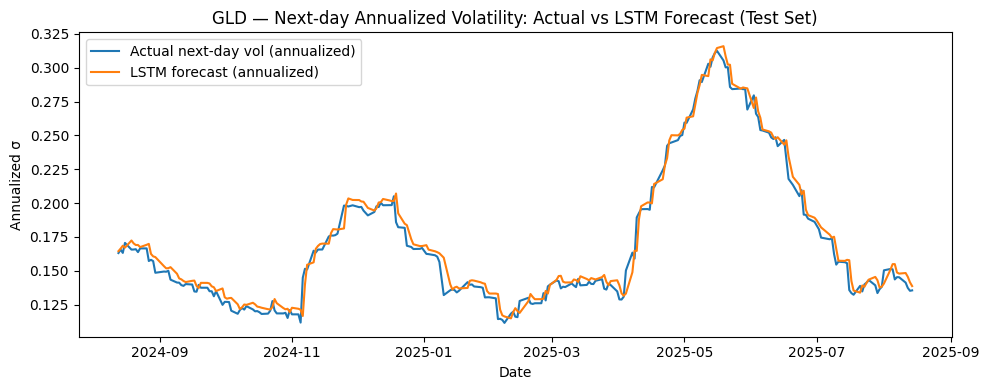

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(true_series.index, true_series.values, label="Actual next-day vol (annualized)")
plt.plot(pred_series.index, pred_series.values, label="LSTM forecast (annualized)")
plt.legend()
plt.title("GLD — Next-day Annualized Volatility: Actual vs LSTM Forecast (Test Set)")
plt.xlabel("Date"); plt.ylabel("Annualized σ")
plt.tight_layout()
plt.show()


XGBOOST+LSTM(HYBRID)

# **Module 3 -Options Pricig Implementation**

In [38]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from datetime import datetime
import yfinance as yf
from scipy.stats import norm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [40]:
# Parameters
asof = pd.Timestamp("2025-08-15")  # day we benchmark
last_train = pd.Timestamp("2024-08-09")  # last day in vol training data

# Pull GLD price as of asof date
ticker = yf.Ticker("GLD")
hist = ticker.history(start=(asof - pd.Timedelta(days=5)).strftime("%Y-%m-%d"),
                      end=(asof + pd.Timedelta(days=1)).strftime("%Y-%m-%d"))

if hist.empty:
    raise ValueError("No price data found for GLD around evaluation date.")

S0 = float(hist["Close"].iloc[-1])  # spot price on asof
print(f"As of {asof.date()}, GLD spot price = {S0:.2f}")


As of 2025-08-15, GLD spot price = 307.43


In [41]:
# Get all available expiries
expiries = ticker.options
exp_dates = sorted(pd.Timestamp(e) for e in expiries if pd.Timestamp(e) > asof)

def pick_horizons(exp_dates, asof, targets=[30, 90, 180]):
    chosen = []
    for t in targets:
        target_date = asof + pd.Timedelta(days=t)
        cand = [d for d in exp_dates if d >= target_date]
        if cand:
            chosen.append(cand[0])
    return sorted(set(chosen))

chosen_expiries = pick_horizons(exp_dates, asof)
print("Chosen expiries:", chosen_expiries)


Chosen expiries: [Timestamp('2025-09-19 00:00:00'), Timestamp('2025-11-21 00:00:00'), Timestamp('2026-03-20 00:00:00')]


In [42]:
def black_scholes_price(S, K, T, r, sigma, option_type="call", q=0.0):
    if T <= 0 or sigma <= 0:
        return max(S - K, 0) if option_type == "call" else max(K - S, 0)
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    if option_type == "call": ##call price
        return S*np.exp(-q*T)*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    else: ##for put price
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*np.exp(-q*T)*norm.cdf(-d1)

def yearfrac(start, end):
    return (end - start).days / 365.0


In [71]:
pred_series

,vol_lstm
Date,
2024-08-13,0.164475
2024-08-14,0.166332
2024-08-15,0.168481
2024-08-16,0.167035
2024-08-19,0.172340
...,...
2025-08-08,0.147861
2025-08-11,0.148303
2025-08-12,0.145494


In [67]:
pred_series.values

array([0.16447467, 0.16633211, 0.16848147, 0.16703482, 0.17234048,
       0.17019074, 0.16898768, 0.1690319 , 0.1674611 , 0.16915397,
       0.1698445 , 0.16240948, 0.16059268, 0.16008349, 0.15331802,
       0.15176147, 0.1518766 , 0.1526238 , 0.14774546, 0.14430195,
       0.14361347, 0.14238888, 0.14162351, 0.14252414, 0.14270847,
       0.13877815, 0.13722076, 0.14101881, 0.14099701, 0.14055791,
       0.13846879, 0.13776383, 0.13498333, 0.13689925, 0.13034971,
       0.12931235, 0.1297343 , 0.12992051, 0.12516536, 0.12163779,
       0.12293506, 0.1250176 , 0.12475217, 0.12630212, 0.1251402 ,
       0.12348261, 0.1231404 , 0.12263609, 0.12153196, 0.1213607 ,
       0.123063  , 0.12905665, 0.12597828, 0.12243246, 0.12145168,
       0.12187517, 0.11935623, 0.12261279, 0.12186672, 0.12113877,
       0.11650334, 0.13979208, 0.15440266, 0.15619281, 0.16618586,
       0.16830651, 0.16970997, 0.17003132, 0.16999495, 0.17777692,
       0.1807409 , 0.18058662, 0.18043323, 0.18122214, 0.19881

In [109]:
# Let's say you have:
# vol_naive, vol_roll, vol_garch, vol_rf, vol_lstm
vol_df=pd.DataFrame()
vol_df['naive']=pd.Series(naive_predictions)
vol_df['rolling']=pd.Series(best_rolling_predictions)
vol_df['garch']=pd.Series(garch_predictions_annualized)
vol_df['rf']=pd.Series(rf_pred)
vol_df['xgboost']=pd.Series(xgb_predictions)
#vol_df['lstm']= pred_series.values
# Step 1: Put them into a DataFrame aligned on their dates

vol_df

,naive,rolling,garch,rf,xgboost
0,0.166329,0.166490,0.154854,0.173218,0.125833
1,0.162037,0.165429,0.151304,0.159910,0.124405
2,0.163845,0.164189,0.150336,0.160846,0.132363
3,0.162570,0.163968,0.147165,0.161356,0.134991
4,0.165060,0.163805,0.161355,0.166482,0.116186
...,...,...,...,...,...
247,0.147727,0.146793,0.148548,0.146627,NaN
248,0.144358,0.147246,0.144460,0.143586,NaN
249,0.153442,0.148700,0.150459,0.151266,NaN
250,0.152679,0.150049,0.146351,0.154395,NaN


In [110]:
pred_df = pred_series.rename("vol_lstm").reset_index()

# Now concat row-wise
vol_df = pd.concat([vol_df, pred_df], axis=1)


In [111]:
vol_df['Date']=pred_series.index

In [112]:
vol_df = vol_df.set_index("Date", drop=True)


In [1]:
vol_df

NameError: name 'vol_df' is not defined

In [86]:
def horizon_sigma_annual(vol_annual_series, start_date, expiry_date, td_per_year=252):
    v_annual = vol_annual_series.sort_index()
    fwd = v_annual.loc[v_annual.index > start_date]
    N_days = len(fwd.loc[fwd.index <= expiry_date])
    if N_days <= 0: return np.nan
    var_daily = (fwd.iloc[:N_days]**2) / td_per_year
    ivar = var_daily.sum()
    return np.sqrt(ivar / N_days * td_per_year)


In [91]:
def get_chain(expiry_str):
    chain = ticker.option_chain(expiry_str)
    calls = chain.calls.copy()
    puts = chain.puts.copy()
    for df in (calls, puts):
        df["mid"] = (df["bid"].fillna(0) + df["ask"].fillna(0)) / 2
    return calls, puts
"""
    vol_series: pd.Series of daily ANNUALIZED sigma forecasts indexed by date (sigma_annual for day t)
    start_date: asof date (forecast date)
    expiry_date: expiry (Timestamp)
    returns: sigma_T as annualized sigma for the expiry horizon
    """
def clean_chain(df, min_oi=10, max_rel_spread=0.25):

    q = df[(df["bid"] > 0) & (df["ask"] > 0)].copy()
    if "openInterest" in q.columns:
        q = q[q["openInterest"] >= min_oi]
    q["rel_spread"] = (q["ask"] - q["bid"]) / q["mid"].replace(0, np.nan)
    q = q[(q["rel_spread"] >= 0) & (q["rel_spread"] <= max_rel_spread)]
    return q.dropna(subset=["mid","strike"])
"""
    Filters illiquid quotes and extreme spreads.
    Expects columns: ['strike','bid','ask','openInterest' (optional)]
    """



"\n    Filters illiquid quotes and extreme spreads.\n    Expects columns: ['strike','bid','ask','openInterest' (optional)]\n    "

In [100]:
pip install fredapi

In [103]:

import pandas as pd
from fredapi import Fred

# Replace with your API key
fred = Fred(api_key="90a1151337f4fb933acc9504928ab857")

fred_series = {
    '1m': 'DTB1',     # 1-Month T-Bill
    '3m': 'DTB3',     # 3-Month T-Bill
    '6m': 'DTB6',     # 6-Month T-Bill
    '1y': 'DGS1',      # 1-Year Treasury Constant Maturity
    '2y': 'DGS2',      # 2-Year Treasury Constant Maturity
}

start_date = '2015-01-01'
end_date = '2025-08-14'

# Download each series and merge into one DataFrame
rates = pd.DataFrame({name: fred.get_series(code, observation_start=start_date, observation_end=end_date)
                      for name, code in fred_series.items()})

# Forward-fill missing data (common for holidays/weekends)
rates = rates.ffill()

print(rates.tail())


                     1m    3m    6m    1y    2y
2025-08-08 00:00:00 NaN  4.14  3.99  3.93  3.76
2025-08-11 00:00:00 NaN  4.15  3.97  3.93  3.76
2025-08-12 00:00:00 NaN  4.14  3.95  3.90  3.72
2025-08-13 00:00:00 NaN  4.11  3.92  3.86  3.67
2025-08-14 00:00:00 NaN  4.12  3.95  3.91  3.74


/tmp/ipython-input-1505201299.py:23: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [104]:
# Replace 1m NaN with 3m as proxy
rates['1m'] = rates['1m'].fillna(rates['3m'])
print(rates.tail())


                       1m    3m    6m    1y    2y
2025-08-08 00:00:00  4.14  4.14  3.99  3.93  3.76
2025-08-11 00:00:00  4.15  4.15  3.97  3.93  3.76
2025-08-12 00:00:00  4.14  4.14  3.95  3.90  3.72
2025-08-13 00:00:00  4.11  4.11  3.92  3.86  3.67
2025-08-14 00:00:00  4.12  4.12  3.95  3.91  3.74


In [106]:
risk_free_dict = {
    "short": 0.0414,   # for < 1 month (or use 1M proxy)
    "1m": 0.0414,
    "3m": 0.0414,
    "6m": 0.0399,
    "1y": 0.0393
}

In [85]:
r_curve = {"short": 0.0425, "med": 0.0393, "long": 0.0376}

def pick_r(T_years):
    days = T_years * 365
    if days <= 90: return r_curve["short"]
    elif days <= 180: return r_curve["med"]
    else: return r_curve["long"]


In [94]:
forecast_cutoff = asof - pd.Timedelta(days=1)  # forecasts must be based on data up to this date
ticker_symbol = "GLD"
target_months = [(2025,9), (2025,11), (2026,2)]  # Sep 2025, Nov 2025, Feb 2026
ticker = yf.Ticker(ticker_symbol)
hist = ticker.history(start=(forecast_cutoff - pd.Timedelta(days=7)).strftime("%Y-%m-%d"),
                      end=(asof + pd.Timedelta(days=1)).strftime("%Y-%m-%d"))
# prefer the close on forecast_cutoff (prior close)
if forecast_cutoff.strftime("%Y-%m-%d") in hist.index.strftime("%Y-%m-%d").tolist():
    S0 = float(hist.loc[hist.index.strftime("%Y-%m-%d") == forecast_cutoff.strftime("%Y-%m-%d")]['Close'].iloc[0])
else:
    S0 = float(hist['Close'].iloc[-2])  # fallback
print("Spot (S0) used for pricing (prior close):", S0)

Spot (S0) used for pricing (prior close): 307.25


In [95]:
# Get available expiries from yfinance
available_expiries = [pd.Timestamp(x) for x in ticker.options]
available_expiries = sorted([d for d in available_expiries if d > asof])

# helper to choose the first expiry at or after each target (year,month)
chosen = []
for (yy, mm) in target_months:
    # target date is first of that month
    target_date = pd.Timestamp(year=yy, month=mm, day=1)
    candidates = [d for d in available_expiries if d >= target_date]
    if candidates:
        chosen.append(candidates[0])

chosen = sorted(list(dict.fromkeys(chosen)))  # unique sorted
print("Chosen expiries (from available yfinance expiries):", chosen)


Chosen expiries (from available yfinance expiries): [Timestamp('2025-09-05 00:00:00'), Timestamp('2025-11-21 00:00:00'), Timestamp('2026-03-20 00:00:00')]


In [1]:
import pandas as pd
import numpy as np

def prepare_option_inputs(spot_series, vol_dict, rates_dict, expiry_dates, valuation_date):
    """
    spot_series: pd.Series of ETF close prices (indexed by date)
    vol_dict: dict of {model_name: pd.Series of forecast volatilities}
    rates_dict: dict of {expiry_label: risk-free rate (as decimal)}
    expiry_dates: dict of {expiry_label: expiry_date (datetime)}
    valuation_date: datetime of pricing
    """
    # Spot price on valuation date
    S = spot_series.loc[valuation_date]

    # Collect inputs into a table
    rows = []
    for expiry_label, expiry_date in expiry_dates.items():
        T = (expiry_date - valuation_date).days / 365.0
        r = rates_dict.get(expiry_label, np.nan)

        for model_name, vol_series in vol_dict.items():
            sigma = vol_series.loc[valuation_date] if valuation_date in vol_series.index else np.nan
            rows.append({
                "expiry": expiry_label,
                "expiry_date": expiry_date,
                "valuation_date": valuation_date,
                "spot": S,
                "r": r,
                "T": T,
                "model": model_name,
                "sigma": sigma
            })

    return pd.DataFrame(rows)


In [2]:
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or np.isnan(S) or np.isnan(K) or np.isnan(r) or np.isnan(sigma):
        return np.nan
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def compute_option_prices(inputs_df, strikes, market_prices=None):
    results = []
    for _, row in inputs_df.iterrows():
        for K in strikes:
            model_price = black_scholes_call(row['spot'], K, row['T'], row['r'], row['sigma'])
            err = np.nan
            if market_prices is not None:
                # compare against actual market option price (if provided)
                mkt = market_prices.get((row['expiry'], K), np.nan)
                err = abs(model_price - mkt) if not np.isnan(mkt) else np.nan
            results.append({
                "valuation_date": row['valuation_date'],
                "expiry": row['expiry'],
                "model": row['model'],
                "strike": K,
                "sigma_T": row['sigma'],
                "model_price": model_price,
                "error": err
            })
    return pd.DataFrame(results)


In [3]:
def summarize_option_prices(results_df):
    pivot = results_df.pivot_table(
        index=["expiry", "strike"],
        columns="model",
        values="model_price"
    )
    return pivot.reset_index()


In [4]:
def add_market_prices(summary_df, market_prices):
    """
    market_prices: dict like {(expiry, strike): price}
    """
    summary_df["market_price"] = summary_df.apply(
        lambda row: market_prices.get((row["expiry"], row["strike"]), np.nan), axis=1
    )
    return summary_df


In [5]:
def evaluate_models(results_df, market_prices):
    metrics = []
    for model in results_df["model"].unique():
        model_df = results_df[results_df["model"] == model].copy()
        model_df["mkt"] = model_df.apply(
            lambda r: market_prices.get((r["expiry"], r["strike"]), np.nan), axis=1
        )
        model_df = model_df.dropna(subset=["mkt", "model_price"])
        if not model_df.empty:
            mae = (abs(model_df["model_price"] - model_df["mkt"])).mean()
            rmse = np.sqrt(((model_df["model_price"] - model_df["mkt"])**2).mean())
            metrics.append({"model": model, "MAE": mae, "RMSE": rmse})
    return pd.DataFrame(metrics)


In [6]:
import matplotlib.pyplot as plt

def plot_model_vs_market(summary_df, expiry):
    subset = summary_df[summary_df["expiry"] == expiry]
    plt.figure(figsize=(8,5))
    for col in subset.columns:
        if col not in ["expiry", "strike", "market_price"]:
            plt.plot(subset["strike"], subset[col], label=col)
    plt.scatter(subset["strike"], subset["market_price"], color="black", marker="x", label="Market")
    plt.title(f"Option Pricing Comparison – {expiry}")
    plt.xlabel("Strike")
    plt.ylabel("Call Price")
    plt.legend()
    plt.show()
